# Read and process bmmflux output

## SCP 1 and 10m EC data from the M-tower

Limited to four evenings in November with a transition between a high- and low-wind regime.

Examining distribution of $w'$ and $T'$ compared to instrument accuracy.

Examining quadrant analysis for evidence of a systematic bias.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# OS interaction
import sys
import os
import gzip

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
context = 'talk'
sns.set_context(context)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

dirData = '/Users/karllapo/Desktop/data/scp/high_frequency_obs/'
dirPrint = '/Users/karllapo/Dropbox/DarkMix/Manuscripts/Snow_Hydro_TurbFeedbacks/graphics'

In [3]:
# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)

# Function to parse the date column within read_csv
def dparse(y, mon, d, h, minute, s, ms):
    x = y + '/' + mon + '/' + d + ' ' + h + ':' + minute + ':' + s + '.' + ms
    d = pd.datetime.strptime(x, '%Y/%m/%d %H:%M:%S.%f')
    return d

## Read the high frequency data from SCP M-tower

- Provided by Lena (who may have gotten this version of the data from Larry Mahrt)

In [5]:
# Go to data directory
towers = ['main_1m', 'main_10m']
ecObs = {}
mtower = {}

for t in towers:
    os.chdir(os.path.join(dirData, t, 'zipped'))
    
    print('--------')
    print(t)
    print('--------')
    print('')
    # Decompress csv file, read it, and write the csv
    raw_data_df = pd.DataFrame()
    zip_files_to_read = [zf for zf in os.listdir() if 'station_' + t + '_scp_tc_2012' in zf and '.gz' in zf
                         and ('322' in zf or '323' in zf or '324' in zf)]
    for zf in zip_files_to_read:
        print(zf)
        raw_data_csv = '.'.join(zf.split('.')[0:2])

        with gzip.open(raw_data_csv + '.gz', 'rb') as f_in, open(raw_data_csv, 'wb') as f_out:
            f_out.write( f_in.read())

        # Read and convert to a pandas dataframe. Convert the date columns to a pandas datetime object.
        raw_data = pd.read_csv(raw_data_csv, delimiter=',',
                               parse_dates={'time':['year', 'month', 'day', 'hour', 'minute', 'second', 'ms']},
                               date_parser=dparse, header=0, index_col='time')

        raw_data_df = raw_data_df.append(raw_data)
        # Remove the extracted csv
        os.remove(raw_data_csv)

    # Create averaging period index
    avg_period = str(int(300)) # seconds
    temp_avgfreq_vec = raw_data_df.groupby(pd.TimeGrouper(avg_period + 's'), as_index=False).\
                                   apply(lambda x: x[x.columns[0]])
    raw_data_df['period'] = temp_avgfreq_vec.index.get_level_values(0)

    # Basic QC variables
    bad_wind_values = (raw_data_df['u'] > 15) | (raw_data_df['v'] > 15) | (raw_data_df['w'] > 15)
    raw_data_df = raw_data_df[~bad_wind_values]

    # Convert to xarray for easier manipulation later
    mtower[t] = xr.Dataset.from_dataframe(raw_data_df)
    mtower[t] = mtower[t].sortby('time')

--------
main_1m
--------

station_main_1m_scp_tc_2012_323_23.csv.gz
station_main_1m_scp_tc_2012_324_03.csv.gz
station_main_1m_scp_tc_2012_323_19.csv.gz
station_main_1m_scp_tc_2012_323_07.csv.gz
station_main_1m_scp_tc_2012_324_11.csv.gz
station_main_1m_scp_tc_2012_323_15.csv.gz
station_main_1m_scp_tc_2012_322_13.csv.gz
station_main_1m_scp_tc_2012_322_01.csv.gz
station_main_1m_scp_tc_2012_322_03.csv.gz
station_main_1m_scp_tc_2012_322_11.csv.gz
station_main_1m_scp_tc_2012_323_21.csv.gz
station_main_1m_scp_tc_2012_323_17.csv.gz
station_main_1m_scp_tc_2012_324_13.csv.gz
station_main_1m_scp_tc_2012_323_09.csv.gz
station_main_1m_scp_tc_2012_323_05.csv.gz
station_main_1m_scp_tc_2012_324_01.csv.gz
station_main_1m_scp_tc_2012_322_23.csv.gz
station_main_1m_scp_tc_2012_322_15.csv.gz
station_main_1m_scp_tc_2012_322_19.csv.gz
station_main_1m_scp_tc_2012_322_07.csv.gz
station_main_1m_scp_tc_2012_323_01.csv.gz
station_main_1m_scp_tc_2012_324_05.csv.gz
station_main_1m_scp_tc_2012_323_13.csv.gz
station

In [9]:
print(mtower['main_10m'])
print(mtower['main_1m'])

<xarray.Dataset>
Dimensions:  (time: 5184000)
Coordinates:
  * time     (time) datetime64[ns] 2012-11-17T01:00:00 ...
Data variables:
    u        (time) float64 2.55 2.458 2.441 2.52 2.606 2.82 2.702 2.616 ...
    v        (time) float64 -1.686 -1.671 -1.615 -1.829 -1.9 -1.951 -1.92 ...
    w        (time) float64 0.2749 0.3801 0.3704 0.3234 0.2575 0.3289 0.378 ...
    T        (time) float64 4.527 4.507 4.502 4.502 4.465 4.384 4.592 4.494 ...
    H2O      (time) float64 5.88 5.886 5.879 5.892 5.877 5.831 5.848 5.884 ...
    CO2      (time) float64 nan nan nan nan nan nan nan nan nan nan nan nan ...
    period   (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
<xarray.Dataset>
Dimensions:  (time: 5184000)
Coordinates:
  * time     (time) datetime64[ns] 2012-11-17T01:00:00 ...
Data variables:
    u        (time) float64 1.021 0.9632 0.9806 0.9779 0.9796 0.994 1.069 ...
    v        (time) float64 -0.04783 -0.06154 -0.07447 -0.06339 -0.03268 ...
    w        (time) flo

In [7]:
mtower['main_10m'] = mtower['main_10m'].sortby('time')
mtower['main_1m'] = mtower['main_1m'].sortby('time')

$\overline{w}$ is approximately zero. The tilt-correction was applied to the entire study period, not just this short period, so that's my explanation.

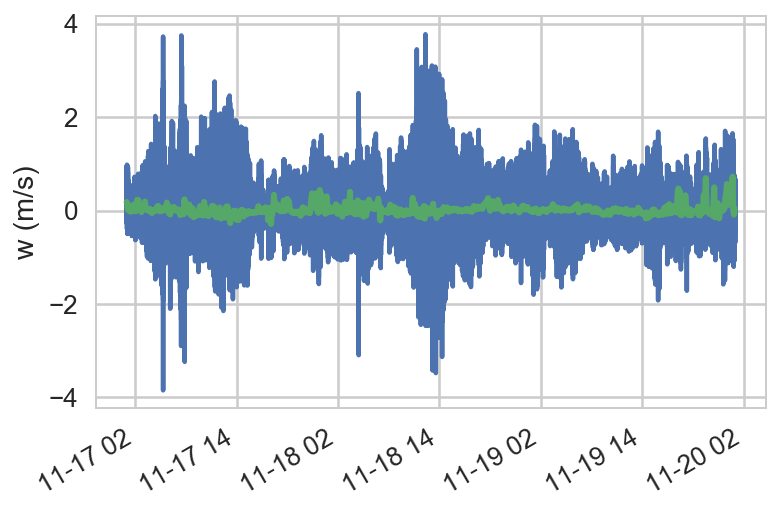

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(mtower['main_10m'].time, mtower['main_10m'].w)
ax.plot(mtower['main_10m'].resample(time='5min').mean().time,
        mtower['main_10m'].w.resample(time='5min').mean(), lw=3)
ax.set_ylabel('w (m/s)')

fig.autofmt_xdate()

Select only the periods that are stable

In [15]:
stable_index = (mtower['main_10m']['T'].values - mtower['main_1m']['T'].values) > 0

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [16]:
def quad_analy(quant1, quant2):
    # Upper right (+ and +)
    quad1 = ((quant1 > 0) & (quant2 > 0)).mean() * 100
    # Upper left (- and +)
    quad2 = ((quant1 < 0) & (quant2 > 0)).mean() * 100
    # Lower right (+ and -)
    quad3 = ((quant1 > 0) & (quant2 < 0)).mean() * 100
    # Lower left (- and -)
    quad4 = ((quant1 < 0) & (quant2 < 0)).mean() * 100

    return([quad1, quad2, quad3, quad4])

In [17]:
def reynolds_decomp(xr_ds, field_name, minutes = 5):

    # Create an index with a unique value for each period of duration 'minutes'
    index = ((np.floor(xr_ds['time.minute'] / minutes)) * minutes * (1 / 60 * 1 / 24)
                      + (xr_ds['time.hour']) * (1 / 24)
                      + (xr_ds['time.dayofyear']))
    index.name = 'duration_minutes'
    
    bar = xr_ds[field_name].groupby(index).mean()
    out_data_array = xr_ds[field_name].groupby(index) - bar

    return(out_data_array)

In [18]:
def standardize(x):
    return (x - x.mean()) / x.std()

In [19]:
# Reynolds decomposition (extract out variance)
top_w_prime = reynolds_decomp(mtower['main_10m'], 'w')
top_t_prime = reynolds_decomp(mtower['main_10m'], 'T')
bottom_w_prime = reynolds_decomp(mtower['main_1m'], 'w')
bottom_t_prime = reynolds_decomp(mtower['main_1m'], 'T')


Text(0,1,'b) 1m obs')

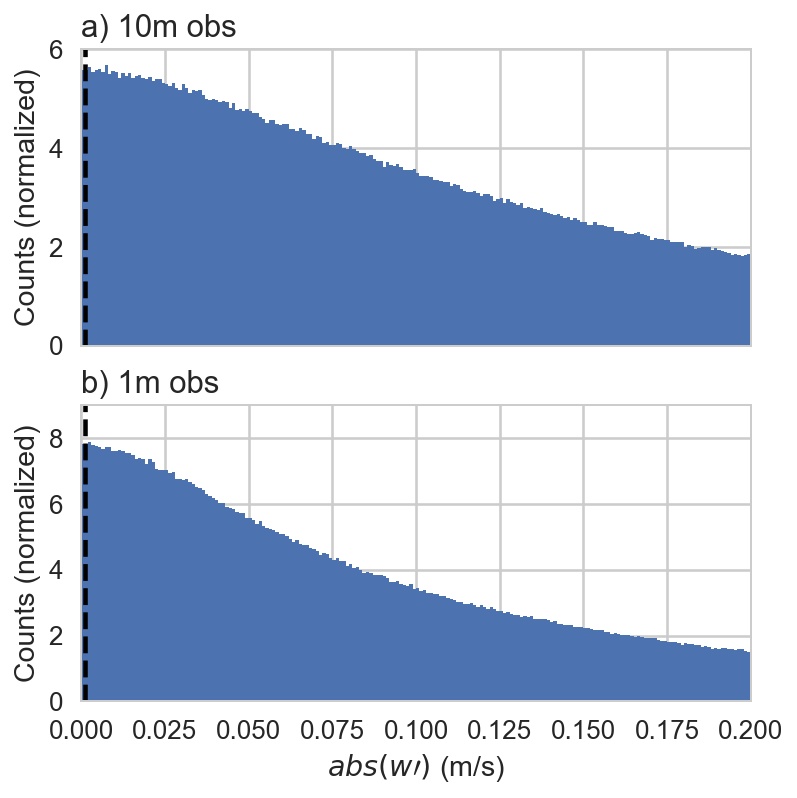

In [27]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
nhigh, bins, _ = ax.hist(np.abs(top_w_prime.where(~np.isnan(top_w_prime) & stable_index, drop=True)),
                         bins=np.arange(0, 0.8, 0.001), normed=True);
ax.plot([0.001, 0.001], [0, 12], 'k--')
ax.set_ylim(0, 6)
ax.set_xlim(0, 0.2)
ax.set_ylabel('Counts (normalized)')
ax.set_title('a) 10m obs', loc='left')

ax = axes[1]
nlow, bins, _ = ax.hist(np.abs(bottom_w_prime.where(~np.isnan(bottom_w_prime) & stable_index, drop=True)),
                        bins=np.arange(0, 0.8, 0.001), normed=True);
ax.plot([0.001, 0.001], [0, 12], 'k--')
ax.set_ylim(0, 9)
ax.set_xlim(0, 0.2)
ax.set_ylabel('Counts (normalized)')
ax.set_xlabel('$abs(w\prime)$ (m/s)')
ax.set_title('b) 1m obs', loc='left')

In [25]:
print(nlow[0] / np.sum(nlow[1:]))
print(nhigh[0] / np.sum(nhigh[1:]))

0.0078886483049361508

Text(0,1,'b) 1m obs')

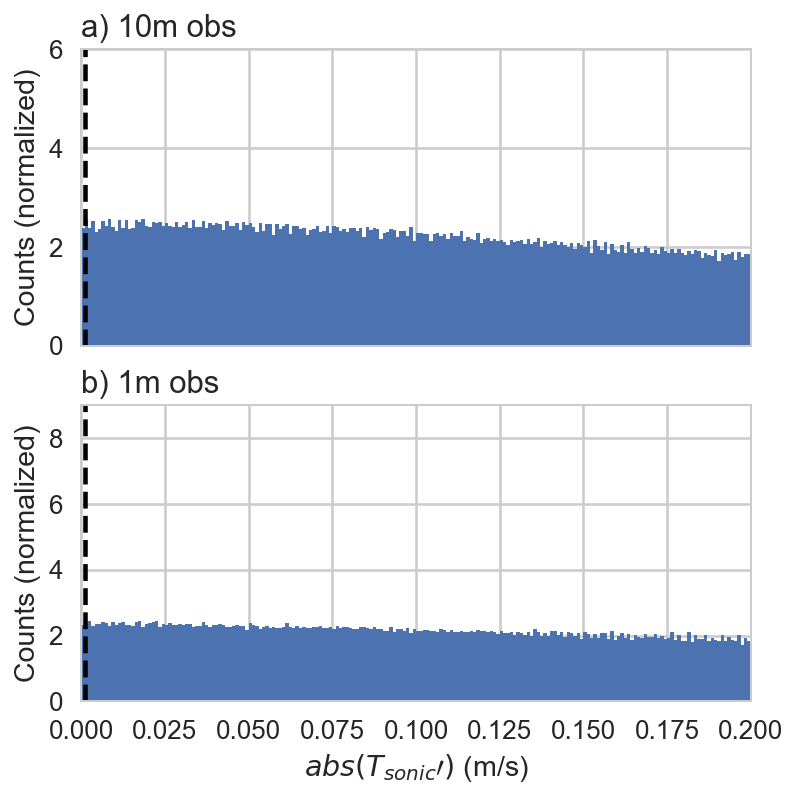

In [28]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
nhigh, bins, _ = ax.hist(np.abs(top_t_prime.where(~np.isnan(top_t_prime) & stable_index, drop=True)),
                         bins=np.arange(0, 0.8, 0.001), normed=True);
ax.plot([0.001, 0.001], [0, 12], 'k--')
ax.set_ylim(0, 6)
ax.set_xlim(0, 0.2)
ax.set_ylabel('Counts (normalized)')
ax.set_title('a) 10m obs', loc='left')

ax = axes[1]
nlow, bins, _ = ax.hist(np.abs(bottom_t_prime.where(~np.isnan(bottom_t_prime) & stable_index, drop=True)),
                        bins=np.arange(0, 0.8, 0.001), normed=True);
ax.plot([0.001, 0.001], [0, 12], 'k--')
ax.set_ylim(0, 9)
ax.set_xlim(0, 0.2)
ax.set_ylabel('Counts (normalized)')
ax.set_xlabel('$abs(T_{sonic}\prime)$ (m/s)')
ax.set_title('b) 1m obs', loc='left')

In [30]:
print(nlow[0] / np.sum(nlow[1:]))
print(nhigh[0] / np.sum(nhigh[1:]))

0.00231371918371
0.0023777101384


In [107]:
def rotate_3D(ds, u_unrot_name='', v_unrot_name='', w_unrot_name=''):
    '''
    Function performing a 3D rotation of u,v,w from sonic anemometer
    performing the first two rotation, i.e. (1) aligning along and cross wind
    components and (2) mean vertical wind equals zero

    Developed and written by Christoph Thomas
    Dept. of Forest Science, Oregon State University, 2006
    Converted to python by Karl lapo
    Micrometeorology Group, University of Bayreuth, 2018
    '''

    # Calculate averages
    u_mean_unrot = np.nanmean(ds[u_unrot_name])
    v_mean_unrot = np.nanmean(ds[v_unrot_name])
    w_mean_unrot = np.nanmean(ds[w_unrot_name])
    
    # Unpack unrotated wind vectors
    u_unrot = ds[u_unrot_name]
    v_unrot = ds[v_unrot_name]
    w_unrot = ds[w_unrot_name]

    # Performing the first rotation (around the w-axis)
    alpha_rot = np.arctan(v_mean_unrot / u_mean_unrot)
    if u_mean_unrot < 0:
        alpha_rot = alpha_rot + np.pi    
    elif v_mean_unrot < 0:
        alpha_rot = alpha_rot + 2 * np.pi
    
    u_rot = (u_unrot * np.cos(alpha_rot)) + (v_unrot * np.sin(alpha_rot))
    v_rot = (-u_unrot * np.sin(alpha_rot)) + (v_unrot * np.cos(alpha_rot))

    # Calculating the second rotation angle beta (mean w equals zero)
    beta_rot = np.arctan2(w_mean_unrot, np.nanmean(u_rot))

    # Performing the second rotation (around the v-axis)
    u_rot = (u_rot * np.cos(beta_rot))  + (w_unrot * np.sin(beta_rot))
    w_rot = -(u_rot * np.sin(beta_rot)) + (w_unrot * np.cos(beta_rot))

    # List of angles
    alpha_rot = np.rad2deg(alpha_rot)
    beta_rot = np.rad2deg(beta_rot)

    # Pack back into the xarray dataset
    ds[u_unrot_name + '_rotated'] = u_rot
    ds[v_unrot_name + '_rotated'] = v_rot
    ds[w_unrot_name + '_rotated'] = w_rot
    ds['alpha'] = beta_rot
    ds['beta'] = alpha_rot
    
    return(ds)


In [108]:
# Rotate the wind vectors -- Mini
proc_data_xr = raw_data_xr.groupby(raw_data_xr.period).apply(rotate_3D,
                                                             u_unrot_name='mini_Ux',
                                                             v_unrot_name='mini_Uy',
                                                             w_unrot_name='mini_Uz')

# Rotate the wind vectors -- CSAT
proc_data_xr = proc_data_xr.groupby(proc_data_xr.period).apply(rotate_3D,
                                                             u_unrot_name='S1_Ux',
                                                             v_unrot_name='S1_Uy',
                                                             w_unrot_name='S1_Uz')

## Quadrant Analysis

In [87]:
def quad_analy(quant1, quant2):
    # Upper right (+ and +)
    quad1 = ((quant1 > 0) & (quant2 > 0)).mean() * 100
    # Upper left (- and +)
    quad2 = ((quant1 < 0) & (quant2 > 0)).mean() * 100
    # Lower right (+ and -)
    quad3 = ((quant1 > 0) & (quant2 < 0)).mean() * 100
    # Lower left (- and -)
    quad4 = ((quant1 < 0) & (quant2 < 0)).mean() * 100

    return([quad1, quad2, quad3, quad4])

In [88]:
def reynolds_decomp(xr_ds, field_name):
    halfhour_index = (xr_ds['time.hour'] / 0.5)
    halfhour_index.name = 'halfHourly'

    bar = xr_ds[field_name].groupby(halfhour_index).mean()
    out_data_array = xr_ds[field_name].groupby(halfhour_index) - bar

    return(out_data_array)

In [110]:
def standardize(x):
    return (x - x.mean()) / x.std()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


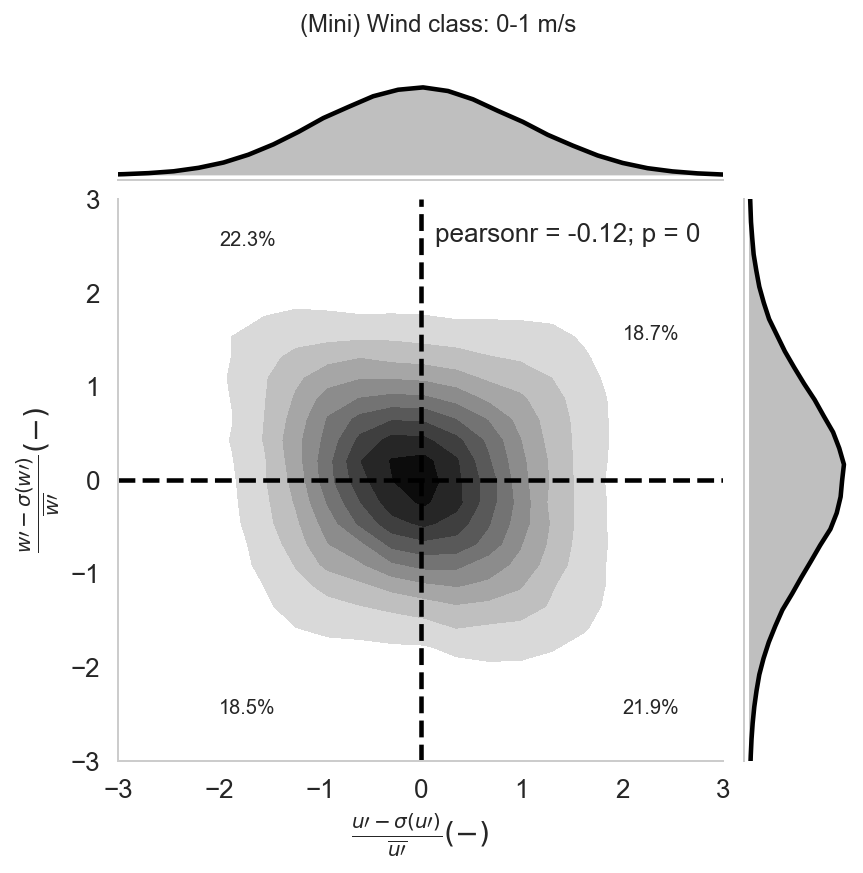

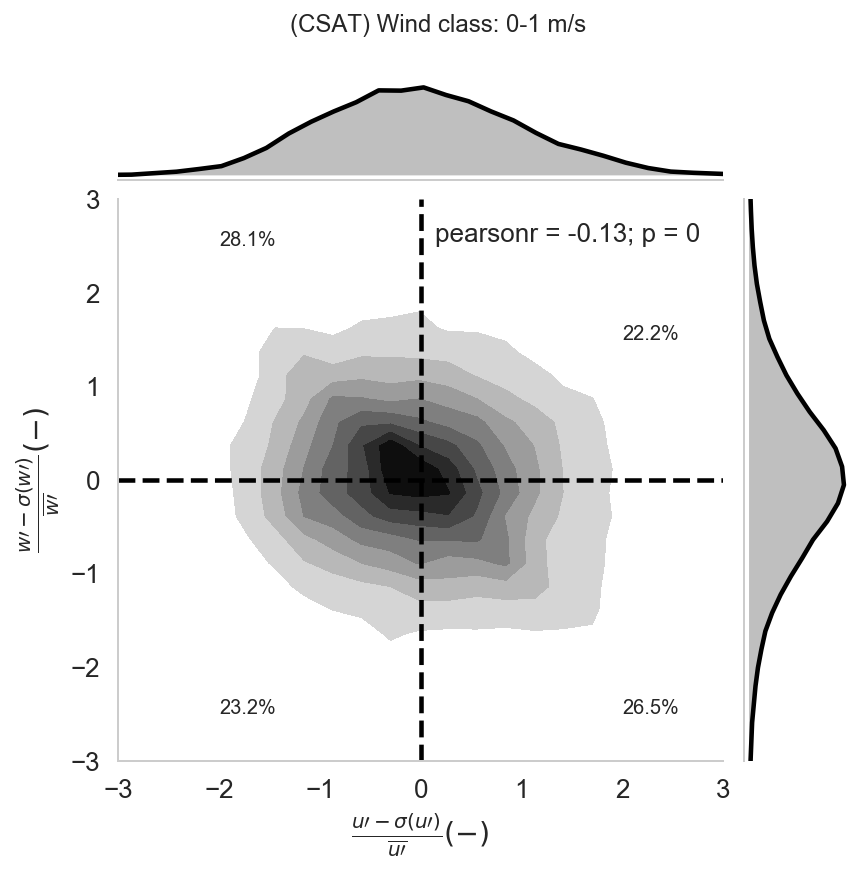

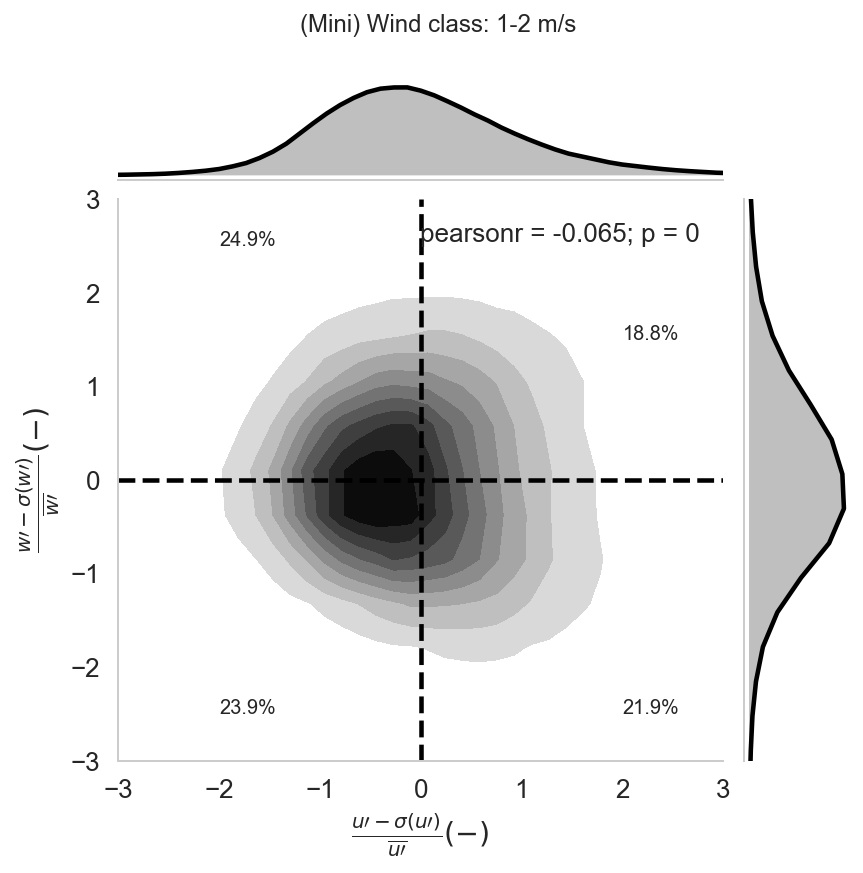

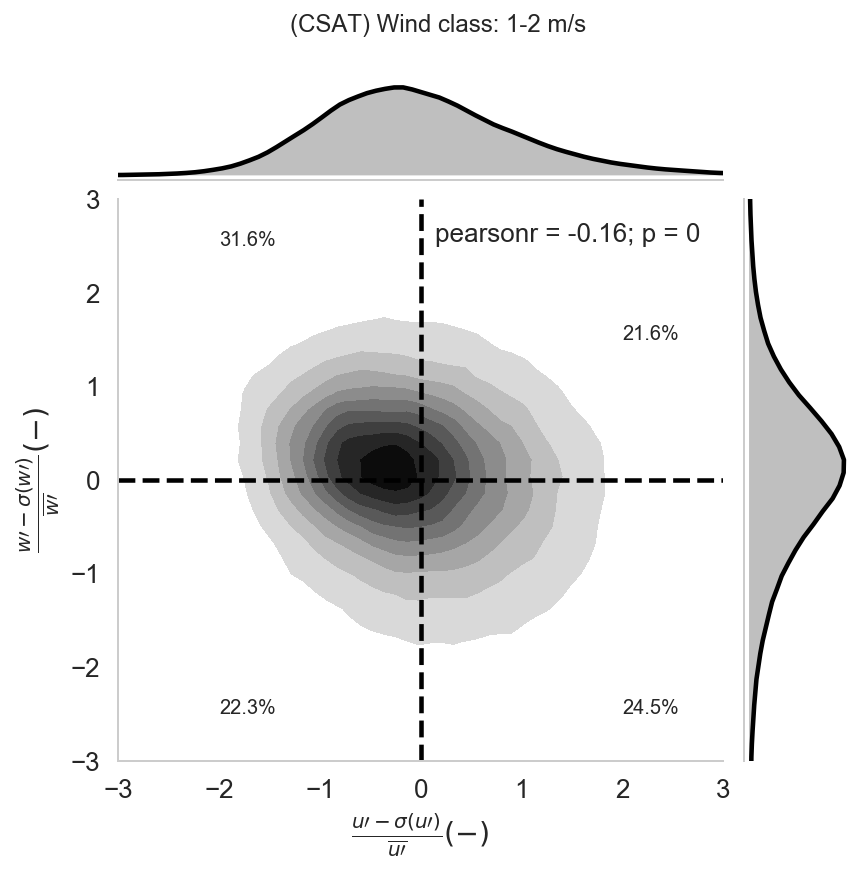

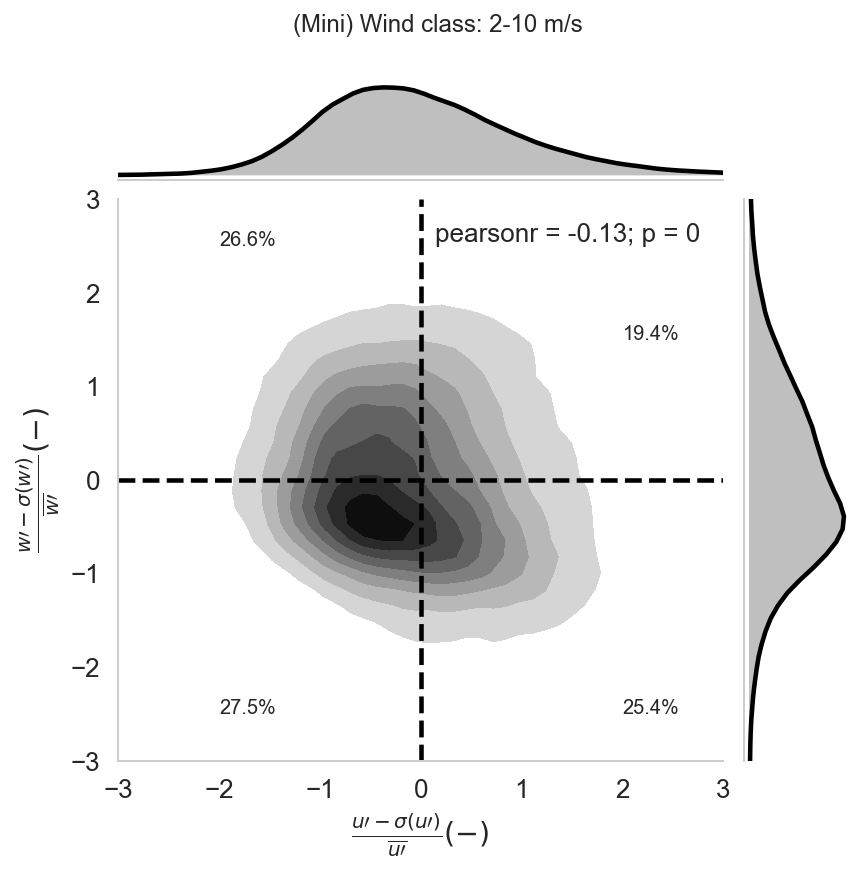

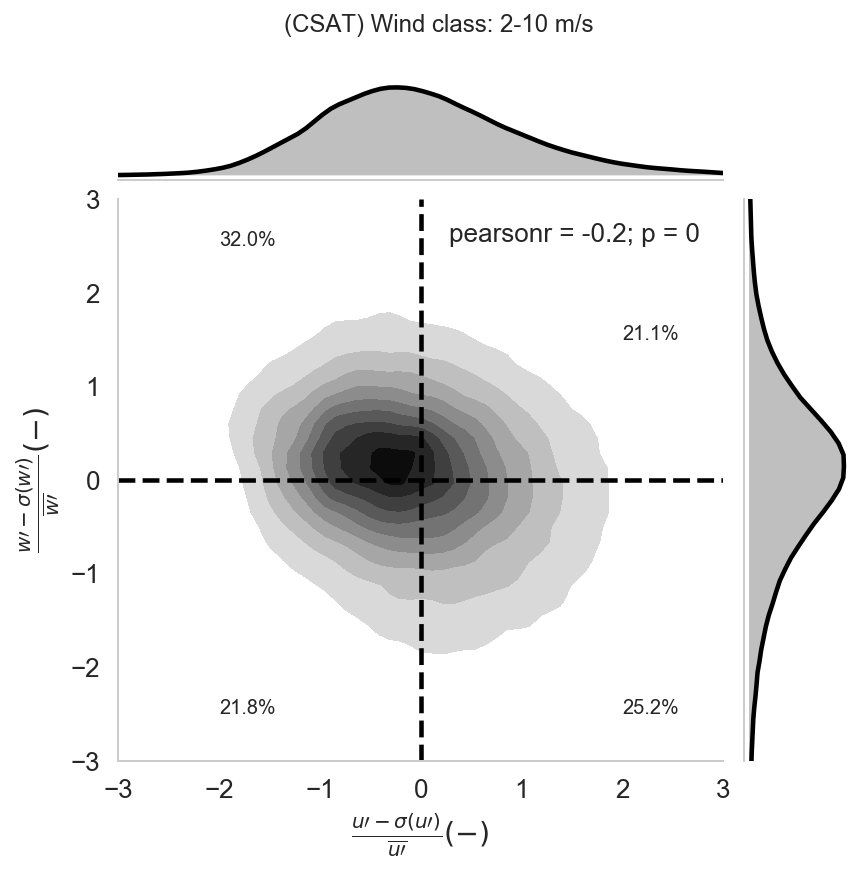

In [123]:
# Limits for the density plots (in standard deviations)
xlim = [-3, 3]
ylim = [-3, 3]

# Get the mean wind speed
ubar_mini = proc_data_xr.mini_Ux_rotated.resample(time='30Min').mean().reindex_like(proc_data_xr, method='pad')
ubar_csat = proc_data_xr.S1_Ux_rotated.resample(time='30Min').mean().reindex_like(proc_data_xr, method='pad')

# Threshold for the wind classes
wind_threshold = [0, 1, 2, 10]

for n in np.arange(0, len(wind_threshold) - 1):
    
    windex = (ubar_mini > wind_threshold[n]) & (ubar_mini < wind_threshold[n + 1]) 
    # Reynolds decomposition (extract out variance)
    mini_u_prime = reynolds_decomp(proc_data_xr.where(windex), 'mini_Ux_rotated')
    mini_v_prime = reynolds_decomp(proc_data_xr.where(windex), 'mini_Uy_rotated')
    mini_w_prime = reynolds_decomp(proc_data_xr.where(windex), 'mini_Uz_rotated')
    
    # Standardize
    mini_u_prime = mini_u_prime.groupby(proc_data_xr.period).apply(standardize)
    mini_v_prime = mini_v_prime.groupby(proc_data_xr.period).apply(standardize)
    mini_w_prime = mini_w_prime.groupby(proc_data_xr.period).apply(standardize)

    # Reynolds decomposition (extract out variance)
    windex = (ubar_csat > wind_threshold[n]) & (ubar_csat < wind_threshold[n + 1])
    csat_u_prime = reynolds_decomp(proc_data_xr.where(windex), 'S1_Ux_rotated')
    csat_v_prime = reynolds_decomp(proc_data_xr.where(windex), 'S1_Uy_rotated')
    csat_w_prime = reynolds_decomp(proc_data_xr.where(windex), 'S1_Uz_rotated')

    # Standardize
    csat_u_prime = csat_u_prime.groupby(proc_data_xr.period).apply(standardize)
    csat_v_prime = csat_v_prime.groupby(proc_data_xr.period).apply(standardize)
    csat_w_prime = csat_w_prime.groupby(proc_data_xr.period).apply(standardize)
    
    mini_quad = quad_analy(mini_u_prime.values[windex], mini_w_prime.values[windex])
    csat_quad = quad_analy(csat_u_prime.values[windex], csat_w_prime.values[windex])
    
    with sns.axes_style({'axes.grid' : False}):
        sns_fg = sns.jointplot(x=mini_u_prime, y=mini_w_prime, kind="kde", color="k", shade_lowest=False)
        ax = sns_fg.ax_joint
        ax.plot(xlim, [0, 0], 'k--')
        ax.plot([0, 0], ylim, 'k--')
        ax.text(max(xlim) - 1, max(ylim) - 1.5, '{:2.1f}'.format(mini_quad[0]) + '%')
        ax.text(min(xlim) + 1, max(ylim) - 0.5, '{:2.1f}'.format(mini_quad[1]) + '%')
        ax.text(max(xlim) - 1, min(ylim) + 0.5, '{:2.1f}'.format(mini_quad[2]) + '%')
        ax.text(min(xlim) + 1, min(ylim) + 0.5, '{:2.1f}'.format(mini_quad[3]) + '%')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(r'$\frac{w \prime - \sigma(w \prime)}{\overline{w \prime}} (-)$')
        ax.set_xlabel(r'$\frac{u \prime - \sigma(u \prime)}{\overline{u \prime}} (-)$')
        title = '(Mini) Wind class: ' + str(wind_threshold[n]) + '-' + str(wind_threshold[n+1]) + ' m/s'
        plt.subplots_adjust(top=0.9)
        sns_fg.fig.suptitle(title)
        
        
        sns_fg = sns.jointplot(x=csat_u_prime, y=csat_w_prime, kind="kde", color="k", shade_lowest=False)
        ax = sns_fg.ax_joint
        ax.plot(xlim, [0, 0], 'k--')
        ax.plot([0, 0], ylim, 'k--')
        ax.text(max(xlim) - 1, max(ylim) - 1.5, '{:2.1f}'.format(csat_quad[0]) + '%')
        ax.text(min(xlim) + 1, max(ylim) - 0.5, '{:2.1f}'.format(csat_quad[1]) + '%')
        ax.text(max(xlim) - 1, min(ylim) + 0.5, '{:2.1f}'.format(csat_quad[2]) + '%')
        ax.text(min(xlim) + 1, min(ylim) + 0.5, '{:2.1f}'.format(csat_quad[3]) + '%')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_ylabel(r'$\frac{w \prime - \sigma(w \prime)}{\overline{w \prime}} (-)$')
        ax.set_xlabel(r'$\frac{u \prime - \sigma(u \prime)}{\overline{u \prime}} (-)$')
        title = '(CSAT) Wind class: ' + str(wind_threshold[n]) + '-' + str(wind_threshold[n+1]) + ' m/s'
        plt.subplots_adjust(top=0.9)
        sns_fg.fig.suptitle(title)

Look at that linear relationship between `w'` and `u'` and `v'`. Super strong. No wonder it does weird things in the integral turbulence characteristic.